In [3]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [5]:
swarms = {}
for file in os.listdir('./temp_swarms/'):
    swarm_name = file.replace('.swm','')
    swarms[swarm_name] = SwarmManager.load(os.path.join('temp_swarms', file))

In [6]:
campaign_dict = {}
for swarm_name, smgr in swarms.items():
        smgr = swarms[swarm_name]
        campaign_dict[swarm_name] = smgr.swarm_picked.sum(axis=1)
   
    
campaign_portfolio = pd.DataFrame(campaign_dict)

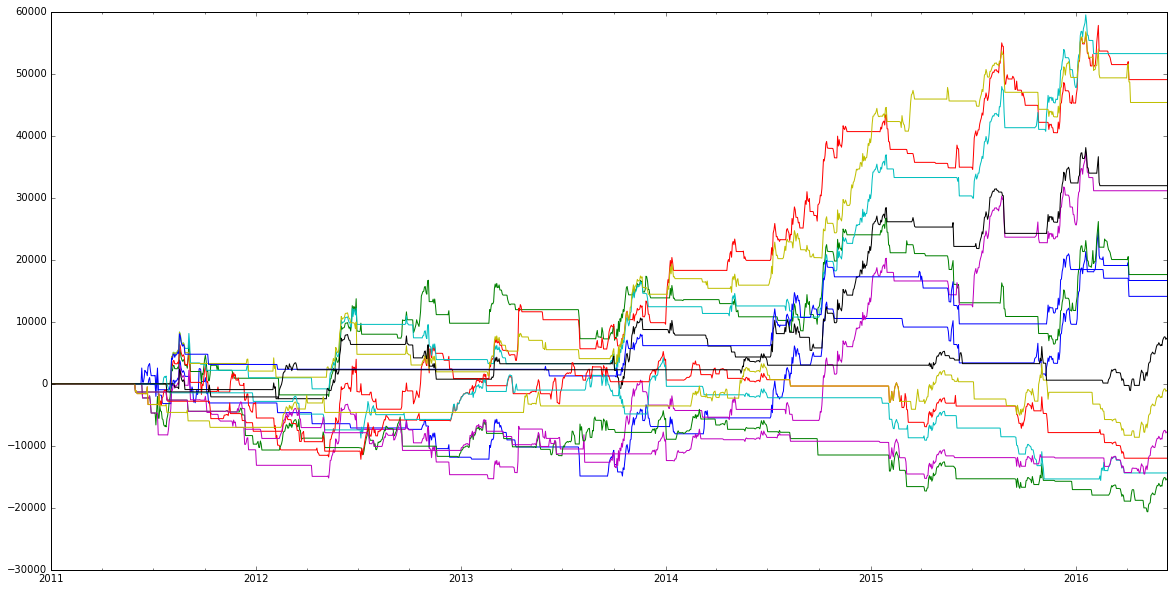

In [9]:
figsize(20,10)
campaign_portfolio.plot(legend=False)

## Rng strategies

In [129]:
#
# random time series
#
df = pd.DataFrame()
for i in range(10):
    
    date = pd.date_range(start='2011-01', end='2016-05', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [136]:
# Real swarms
df = campaign_portfolio

# Rng strategies
#df = df

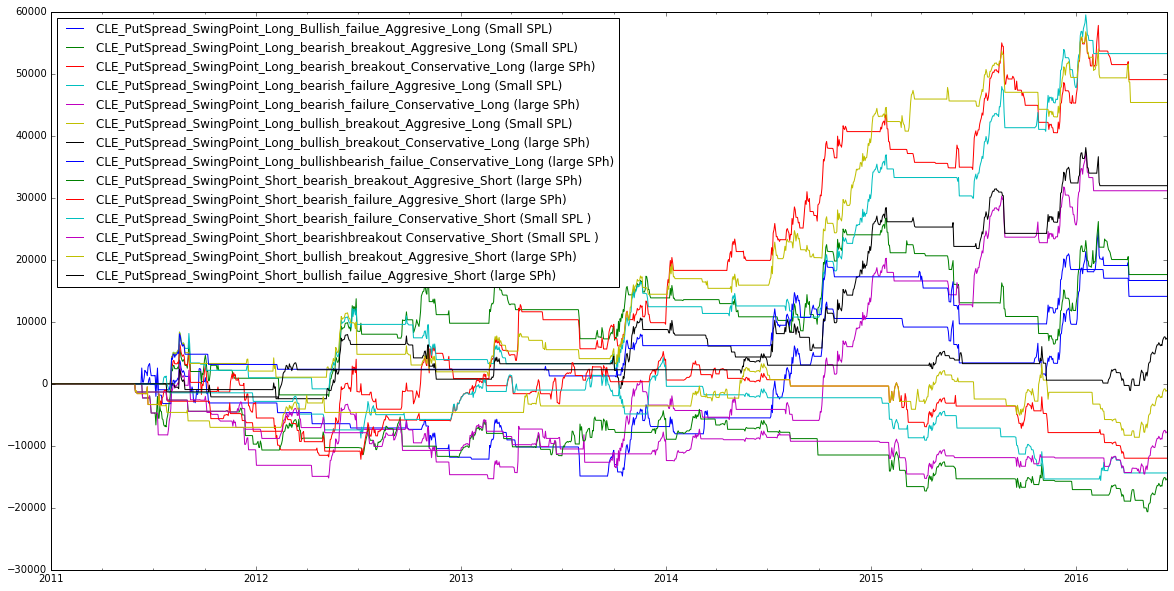

In [137]:
df.plot()

# Metrics calc

In [148]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = newyear # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'pricechange_modsharpe': modsharpe, 
                    'netprofit': netprofit,
                    'max_dd': max_dd, 'recovery_factor': netprofit / np.abs(max_dd),
                    'profit_factor': profit_factor, 'winrate': winrate }
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

In [149]:
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

sorted_df = stats_df.sort_values('pricechange_modsharpe',ascending=False)


temp_var = sorted_df[sorted_df.rebalance_index == 2] # change rebalance index value to select different rebalance periods
                                                     # TEMPORARY

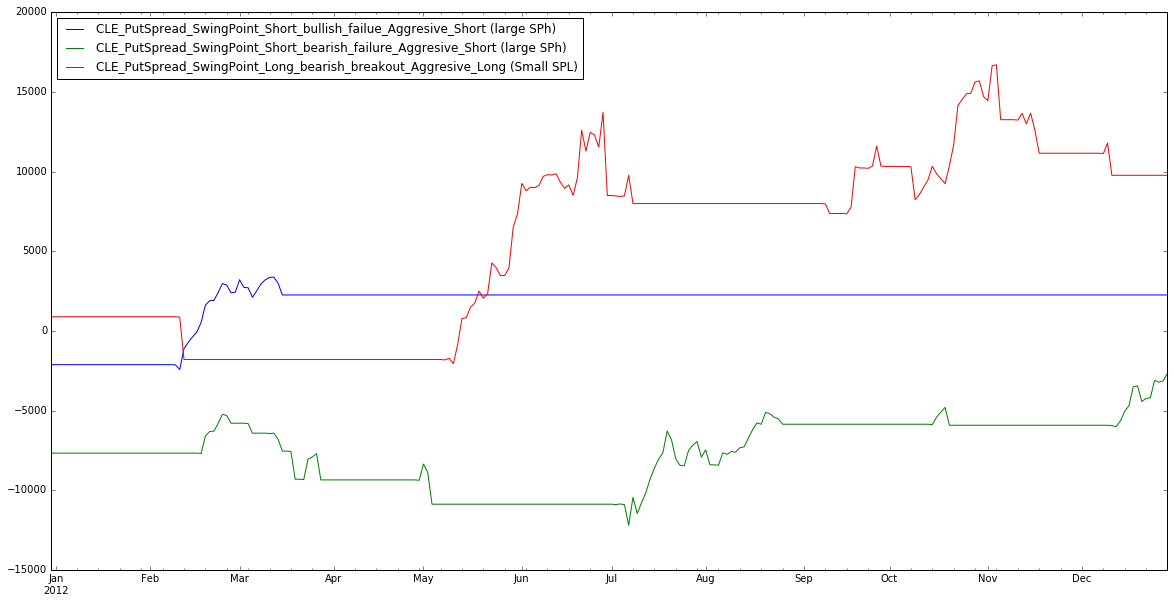

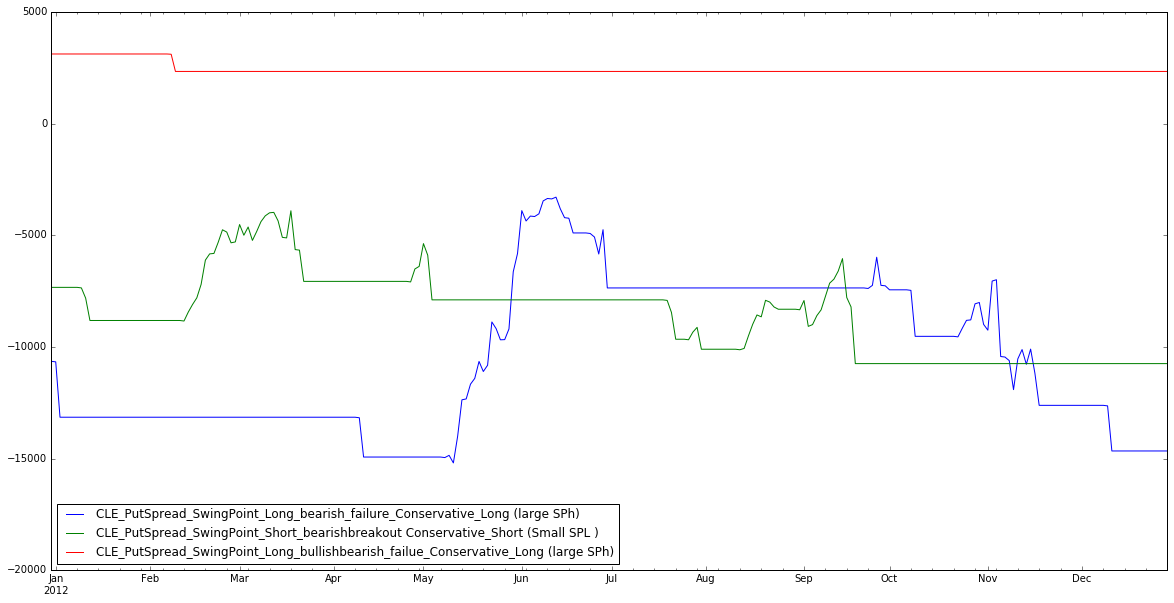

In [150]:
# Three best strats. Defined by shapre ratio
df[temp_var.strategy.values[:3]].ix[temp_var.rebalance_date_start.values[0] : temp_var.rebalance_date_end.values[0]].plot()
# Three worst strats. Defined by shapre ratio
df[temp_var.strategy.values[-4:-1]].ix[temp_var.rebalance_date_start.values[0] : temp_var.rebalance_date_end.values[0]].plot()

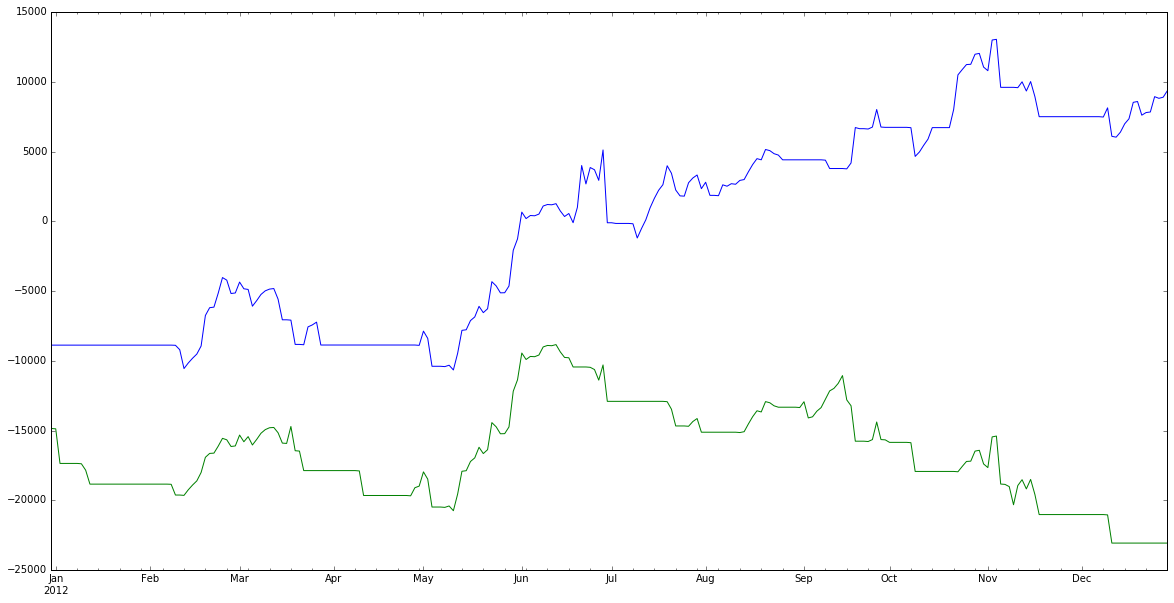

In [151]:
# Three best strats, summary equities - blue
# Defined by shapre ratio
df[temp_var.strategy.values[:3]].ix[temp_var.rebalance_date_start.values[0] : temp_var.rebalance_date_end.values[0]].sum(axis=1).plot()
# Three worst strats, summary equities - green
# Defined by shapre ratio
df[temp_var.strategy.values[-4:-1]].ix[temp_var.rebalance_date_start.values[0] : temp_var.rebalance_date_end.values[0]].sum(axis=1).plot()

In [152]:
temp_var

,max_dd,netprofit,pricechange_modsharpe,profit_factor,rebalance_date_end,rebalance_date_start,rebalance_index,recovery_factor,strategy,winrate
27,-1120.0,4372.0,0.103428,2.405788,2012-12-31,2011-12-30,2,3.903571,CLE_PutSpread_SwingPoint_Short_bullish_failue_...,6.513410
23,-6964.0,5004.0,0.049351,1.276098,2012-12-31,2011-12-30,2,0.718553,CLE_PutSpread_SwingPoint_Short_bearish_failure...,16.858238
15,-6928.0,8872.0,0.047708,1.287940,2012-12-31,2011-12-30,2,1.280600,CLE_PutSpread_SwingPoint_Long_bearish_breakout...,18.007663
26,-2764.0,2408.0,0.039263,1.363966,2012-12-31,2011-12-30,2,0.871201,CLE_PutSpread_SwingPoint_Short_bullish_breakou...,6.896552
17,-8286.0,2936.0,0.020340,1.125847,2012-12-31,2011-12-30,2,0.354333,CLE_PutSpread_SwingPoint_Long_bearish_failure_...,12.643678
16,-8760.0,4078.0,0.019700,1.094679,2012-12-31,2011-12-30,2,0.465525,CLE_PutSpread_SwingPoint_Long_bearish_breakout...,21.455939
20,-7208.0,1672.0,0.013762,1.092724,2012-12-31,2011-12-30,2,0.231964,CLE_PutSpread_SwingPoint_Long_bullish_breakout...,11.111111
24,-6752.0,140.0,0.001608,1.009887,2012-12-31,2011-12-30,2,0.020735,CLE_PutSpread_SwingPoint_Short_bearish_failure...,10.344828
19,-9516.0,-120.0,-0.000763,0.995260,2012-12-31,2011-12-30,2,-0.012610,CLE_PutSpread_SwingPoint_Long_bullish_breakout...,13.026820
22,-6492.0,-1536.0,-0.013842,0.937591,2012-12-31,2011-12-30,2,-0.236599,CLE_PutSpread_SwingPoint_Short_bearish_breakou...,18.773946


In [147]:
stats_df

,max_dd,netprofit,pricechange_modsharpe,profit_factor,rebalance_date_end,rebalance_date_start,rebalance_index,recovery_factor,strategy,winrate
0,-6934.0,-3090.0,-0.019600,0.890959,2011-12-30,2011-01-03,1,-0.445630,CLE_PutSpread_SwingPoint_Long_Bullish_failue_A...,10.038610
1,-6948.0,898.0,0.005163,1.027443,2011-12-30,2011-01-03,1,0.129246,CLE_PutSpread_SwingPoint_Long_bearish_breakout...,11.196911
2,-11000.0,-3232.0,-0.022845,0.875520,2011-12-30,2011-01-03,1,-0.293818,CLE_PutSpread_SwingPoint_Long_bearish_breakout...,10.424710
3,-7382.0,970.0,0.008688,1.081499,2011-12-30,2011-01-03,1,0.131401,CLE_PutSpread_SwingPoint_Long_bearish_failure_...,4.633205
4,-13706.0,-10642.0,-0.070704,0.632401,2011-12-30,2011-01-03,1,-0.776448,CLE_PutSpread_SwingPoint_Long_bearish_failure_...,8.108108
5,-6276.0,2052.0,0.022114,1.246161,2011-12-30,2011-01-03,1,0.326960,CLE_PutSpread_SwingPoint_Long_bullish_breakout...,4.247104
6,-3280.0,-928.0,-0.015815,0.785582,2011-12-30,2011-01-03,1,-0.282927,CLE_PutSpread_SwingPoint_Long_bullish_breakout...,0.772201
7,-4924.0,3128.0,0.025638,1.242933,2011-12-30,2011-01-03,1,0.635256,CLE_PutSpread_SwingPoint_Long_bullishbearish_f...,5.791506
8,-9732.0,-9732.0,-0.134883,0.072082,2011-12-30,2011-01-03,1,-1.000000,CLE_PutSpread_SwingPoint_Short_bearish_breakou...,2.316602
9,-7656.0,-7656.0,-0.079185,0.547304,2011-12-30,2011-01-03,1,-1.000000,CLE_PutSpread_SwingPoint_Short_bearish_failure...,6.563707


In [49]:
temp_var.rebalance_date_start.values[0]

numpy.datetime64('2015-01-31T02:00:00.000000000+0200')

In [50]:
temp_var.rebalance_date_end.values[0]

numpy.datetime64('2015-02-28T02:00:00.000000000+0200')

In [ ]:
CLE_PutSpread_SwingPoint_Short_bearish_breakou